In [1]:
# С:<
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
# from tsfresh import extract_features
from sklearn import model_selection
from sklearn import linear_model as lm
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pmdarima as pm

In [2]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, feature_indices):
        self.feature_indices = feature_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        selected_features = []
        for window_array in X:
            selected_window_features = window_array[self.feature_indices]
            selected_features.append(np.array(selected_window_features))
        return np.array(selected_features)

In [3]:
class FlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_flat = np.array([np.array(window.values.flatten()) for window in X])
        return X_flat

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
_mape_ = mean_absolute_percentage_error

In [5]:
def windows_extracting(ds, data_window_size=30, label_window_size=7):
    """Возвращает список всех промежутков по <data_window_size> строк,
       и список соответствующих последующих промежутков по <label_window_size> строк"""
    # Создание списков, содержащих промежутки данных по <data_window_size> дней
    data_windows = []
    # Всего должно быть len(dataset) - data_window_size + 1 - label_window_size списков; индексация от 0
    for i in range(len(ds) - data_window_size + 1 - label_window_size):
        data_windows.append(ds[i:i + data_window_size])  # exclusive!

    # Создание списков с метками (y) для каждого промежутка, содержащих <label_window_size> последующих дней
    label_windows = []
    for i in range(data_window_size, len(data_windows) + data_window_size):
        label_windows.append(ds[i:i + label_window_size]['<CLOSE>'])
    # Проверка, что длины data_windows и label_windows совпадают
    assert len(data_windows) == len(label_windows)

    # Проверка, что последние промежутки не "зажевались"
    assert len(data_windows[-1]) == data_window_size and len(label_windows[-1]) == label_window_size

    return data_windows, label_windows

In [6]:
def validate_result(model, model_name, validation_X, validation_y, pred_window_size):
    # validation_X = validation_X[0:-1:pred_window_size]
    # validation_y = validation_y[0:-1:pred_window_size]
    plt.figure(figsize=(10, 6))
    predicted_data = []
    real_data = []
    losses = []
    validation_X = validation_X[0:-1:pred_window_size]
    validation_y = validation_y[0:-1:pred_window_size]
    for i in range(0, len(validation_X)):
        y_pred = model.predict([validation_X[i]])
        predicted_data.extend(y_pred[0])
        real_data.extend(validation_y[i])

        # Оценка модели
        # mse = mean_squared_error([y_test[i]], y_pred)
        mape = mean_absolute_percentage_error(validation_y[i], y_pred)
        losses.append(mape)
    # predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(real_data, predicted_data))
    print('RMSE: ', RSME_score)

    R2_score = r2_score(real_data, predicted_data)
    print('R2 score: ', R2_score)
    indexes = np.concatenate([df.index for df in validation_y])
    # print(indexes)
    plt.plot(indexes, predicted_data, 'r', label='Предсказания')  # validation_y.index,
    plt.plot(indexes, real_data, 'b', label='Реальные данные')
    # Установка значений для оси X
    plt.ylabel('Цена закрытия')
    # Установка шага для отображения дат
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
    plt.title(model_name + ' Предсказания и реальные данные')
    plt.legend(loc='upper right')
    plt.show()
    plt.plot(losses)
    plt.xlabel(f'Средняя ошибка (%): {np.mean(losses)}')
    plt.show()

In [7]:
def add_features(dataset):

    features_ds = pd.read_csv("DataSources/extracted_features_cleaned.csv").iloc[:,
                  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
    features_ds.index = dataset.index
    print("features_ds.shape: ", features_ds.shape)
    print(features_ds.head())
    print(features_ds.iloc[1])
    print("=====features dataset concat=====")
    # dataset = dataset.join(features_ds)
    dataset = pd.concat([dataset, features_ds], axis=1)

    dataset['<PRICE_CHANGE>'] = dataset['<CLOSE>'] - dataset['<OPEN>']
    dataset['<PRICE_RANGE>'] = dataset['<HIGH>'] - dataset['<LOW>']

    # Скользящее среднее за последние <window> дней.
    dataset['<MA_7>'] = dataset['<CLOSE>'].rolling(window=7).mean()

    # Экспоненциальное скользящее среднее за последние <span> дней.
    dataset['<EMA_14>'] = dataset['<CLOSE>'].ewm(span=14, min_periods=0, adjust=False).mean()

    # Скользящее стандартное отклонение за последние <window> дней.
    dataset['<STD_30>'] = dataset['<CLOSE>'].rolling(window=30).std()

    # Лаги цен за последние <i in range(1, 4)> дней.
    for i in range(1, 4):
        dataset[f'<Price_Lag_{i}>'] = dataset['<CLOSE>'].shift(i)

    dataset.fillna(0, inplace=True)
    return dataset


In [8]:
def features_work(dataset):
    indexed_dataset = dataset.copy()
    """def row_index_comeback(row):
        return row.index"""
    indexed_dataset = indexed_dataset.assign(row_number=range(len(indexed_dataset)))
    print('============================')
    print(indexed_dataset)
    print('============================')
    # ef = extract_features(indexed_dataset, column_id='row_number')
    ef = pd.read_csv("DataSources/extracted_features.csv")
    # Удаление столбцов, состоящих только из нулей
    # ef = ef.loc[:, (ef != 0).any(axis=0)]
    # Удаление столбцов, в которых Nan превышает 75%, оставшиеся Nan заполняет значениями 0
    ef = ef.dropna(axis=1, thresh=int(len(ef)/4)-1).fillna(0)  # how="all",
    # Удаление столбцов с одинаковыми значениями во всех строкаж
    ef = ef[[i for i in ef if ef[i].nunique() > 1]]
    """uniq_counts = ef.value_counts()
    print(uniq_counts)"""
    # Удаление столбцов, в 75% строках которых стоит значение 0 или 1
    print(len(ef.columns))
    ef = ef[ef.columns[(ef == 0).mean() < 0.75]]
    print(len(ef.columns))
    ef = ef[ef.columns[(ef == 1).mean() < 0.75]]
    print(len(ef.columns))
    """nunique = ef.nunique()
    cols_to_drop = nunique[nunique == 1].index
    ef = ef.drop(cols_to_drop, axis=1)"""

    print(ef.head())
    print(ef.columns.tolist())
    print(ef.shape)
    # ef.to_csv('DataSources/extracted_features_cleaned.csv', index=False)

            <OPEN>  <HIGH>  <LOW>  <CLOSE>  <VOL>
<DATE>                                           
2007-09-04   674.7   674.9  674.5    674.9      0
2007-09-05   674.8   685.3  674.4    684.1    884
2007-09-06   683.5   685.5  681.0    685.0    623
2007-09-07   684.0   700.4  684.0    698.0   2004
2007-09-08   697.0   710.0  695.1    704.0   1588
            <OPEN>  <HIGH>   <LOW>  <CLOSE>   <VOL>
<DATE>                                             
2007-09-04   674.7   674.9   674.5    674.9       0
2007-09-05   674.8   685.3   674.4    684.1     884
2007-09-06   683.5   685.5   681.0    685.0     623
2007-09-07   684.0   700.4   684.0    698.0    2004
2007-09-08   697.0   710.0   695.1    704.0    1588
...            ...     ...     ...      ...     ...
2024-03-16  2168.6  2176.9  2158.8   2162.0  153772
2024-03-18  2158.8  2160.8  2149.3   2149.9   41122
2024-03-19  2149.9  2167.2  2149.2   2164.9  148277
2024-03-20  2164.8  2165.5  2150.2   2163.0  139001
2024-03-21  2163.0  2168.2

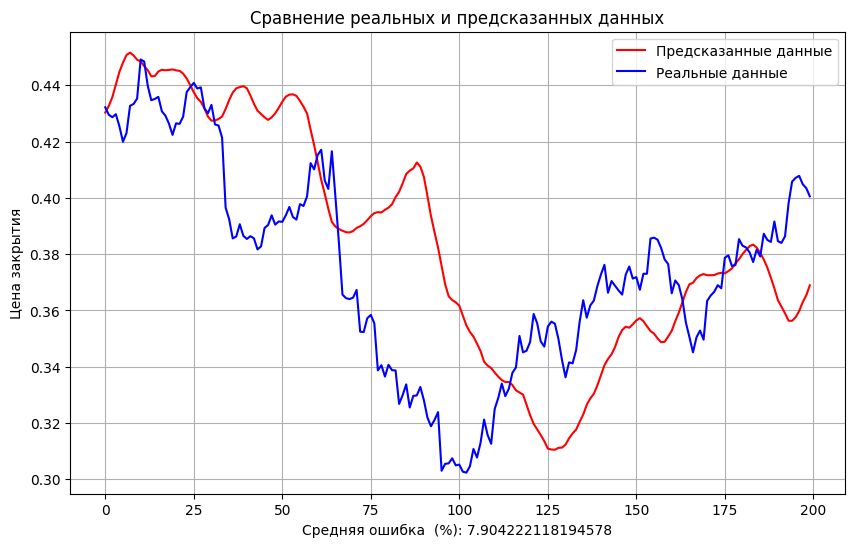

RMSE:  0.043244070204395746
R2 score:  0.951431407836601


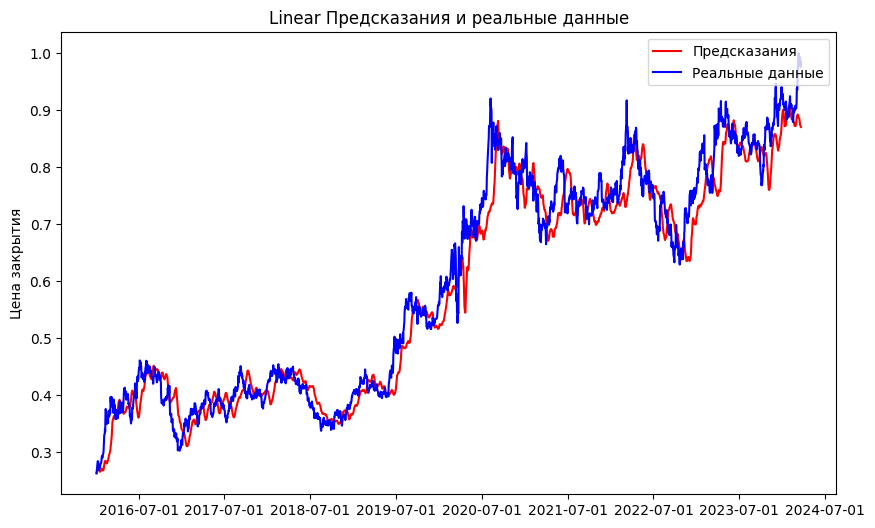

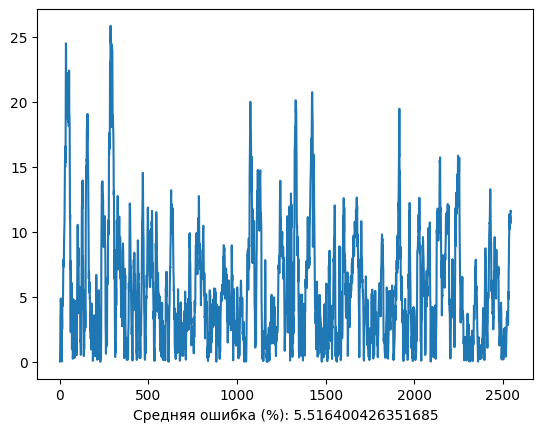

"extracted_features = extract_features(dataset, column_id='<DATE>')\n\n# Вывод извлеченных признаков на экран\nprint(extracted_features)\nextracted_features.to_csv('DataSources/extracted_features.csv', index=False)"

In [9]:

# Task.init(project_name="GoldPrediction", task_name="1step")
# Импорт датасетов. Формат даты в исходниках yymmdd преобразуется с помощью parse_dates
df1 = pd.read_csv("DataSources/GC_070904_090320.csv", parse_dates=[0],
                    usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])  # , index_col=['<DATE>']
df2 = pd.read_csv("DataSources/GC_090321_140320.csv", parse_dates=[0],
                    usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
df3 = pd.read_csv("DataSources/GC_140321_190320.csv", parse_dates=[0],
                    usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
df4 = pd.read_csv("DataSources/GC_190321_240319.csv", parse_dates=[0],
                    usecols=lambda x: x != '<TIME>', index_col=['<DATE>'])
print(df1.head())

# Объединение датасетов
dataset = pd.concat([df1, df2, df3, df4])  # , ignore_index=True
# Удаление повторяющихся строк
dataset = dataset[~dataset.index.duplicated()]
# print(dataset.isnull().sum())
scaler = MinMaxScaler(feature_range=(0, 1))
"""dataset[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']] = (
    scaler.fit_transform(dataset[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]))"""

print(dataset)
print(dataset.head())
print("dataset.shape: ", dataset.shape)

"""plt.plot(dataset['<CLOSE>'], label="Close values")
plt.legend()
plt.show()"""

dataset = add_features(dataset)

# dataset.to_csv('GoldPrediction\DataSources\concat_data.csv')
# dataset = dataset.merge(dataset, left_index=True, right_index=True)
# print(dataset.columns())

print("features added")
# Печать первых нескольких строк для проверки.
print(dataset.head())
print(dataset.iloc[1])
print(dataset.head())

# Получение списка всех колонок датасета
columns = dataset.columns

# Применение scaler к каждой колонке отдельно
for column in columns:
    dataset[column] = scaler.fit_transform(dataset[[column]])
# dataset.to_csv('GoldPrediction\DataSources\concat_data.csv')

# Определили оценками маловажные признаки и теперь их убираем
# dataset.drop(dataset.columns[[5, 6, 9]], axis=1, inplace=True)
# !!! сколько дней нужно предсказать
pred_window_size = 1
data_windows, label_windows = windows_extracting(dataset, data_window_size=30, label_window_size=pred_window_size)

# Преобразование списков окон данных и меток в массивы numpy
X = data_windows
y = label_windows

# Получение размеров списков X и y
num_windows = len(X)
print("Количество окон в X:", num_windows)
print("Количество окон в y:", len(y))

# Разделение данных на обучающий и тестовый наборы
split = num_windows // 2
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Создание и обучение модели линейной регрессии
# model = LinearRegression()
# model = lm.MultiTaskLassoCV(n_alphas=1000, max_iter=6000, random_state=0)
# model = lm.RidgeCV()
# Преобразование X_train и X_test в двумерные списки

# Конвейер, чтобы преобразовать данные в одномерные массивы внутри модели, а снаружи передавать массив.
steps = [
    ('flat', FlattenTransformer()),  # Преобразование в одномерные массивы
    # ('feature_extractor', FeatureExtractor(np.arange(390))),  # Извлечение нужных признаков
    # ('feature_selector', SelectKBest(score_func=f_regression, k=300)),
    ('feature_selection', SelectFromModel(LinearRegression())),
    # ('model', LinearRegression())  # Модель
    ('model', lm.MultiTaskLassoCV(n_alphas=1000, max_iter=6000, random_state=0))  # Модель
]

# Создаем конвейер, передавая список этапов.
model = Pipeline(steps)
# Строка: все признаки 1-го дня, все признаки 2-го дня, все признаки 3-го дня, ...
X_train_flat = np.array([np.array(window.values.flatten()) for window in X_train])
print("Строка датасета: ", X_train_flat[0])
print("Длина строки тренировочного датасета: ", len(X_train_flat[0]))
X_test_flat = np.array([np.array(window.values.flatten()) for window in X_test])

print("Обучение модели...")
# fitted_model = model.fit(X_train, y_train)

# selected_model = SelectFromModel(fitted_model, prefit=True)
# selected_model.fit(X_train, y_train)
"""sup = model['feature_selector'].get_support()
sup_indexes = np.where(sup == True)[0].tolist()
print(sup_indexes, type(sup_indexes), type(sup_indexes[0]))
marks = np.zeros(13)
for i in sup_indexes:
    marks[i % 13] += 1
print(marks)"""
# X_train_flat = X_train_flat[:, sup_indexes]
# X_test_flat = X_test_flat[:, sup_indexes]
model = model.fit(X_train, y_train)
# feature_importances = np.where(model.named_steps['feature_selector'].get_support()==True)[0].tolist()
"""for feature, importance in enumerate(feature_importances):
    print(f"Feature {feature}: Importance = {importance}")"""
# Списки для хранения предсказанных и реальных данных
predicted_data = []
real_data = []

# Построение графиков предсказанных и реальных данных
left_border = 200
right_border = 400
losses = []
print("Тест модели")
for i in range(left_border, right_border, pred_window_size):
    y_pred = model.predict([X_test[i]])
    predicted_data.extend(y_pred[0])
    real_data.extend(y_test[i])

    # Оценка модели
    # mse = mean_squared_error([y_test[i]], y_pred)
    mape = mean_absolute_percentage_error(y_test[i], y_pred)
    losses.append(mape)
    # print("Средняя относительная ошибка (MAPE):", mape)
    # print([X_test_flat[i]])
    # print([y_test[-left_border+i]])
total_loss = np.mean(losses)
# Построение графика предсказанных и реальных данных
plt.figure(figsize=(10, 6))
plt.plot(predicted_data, label='Предсказанные данные', color='red')
plt.plot(real_data, label='Реальные данные', color='blue')
plt.title('Сравнение реальных и предсказанных данных')
plt.xlabel(f'Средняя ошибка  (%): {total_loss}')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.show()
validate_result(model, "Linear", X_test, y_test, pred_window_size)
"""plt.plot(dataset['<VOL>'], label="Volatility values")
plt.legend()
plt.show()"""

"""extracted_features = extract_features(dataset, column_id='<DATE>')

# Вывод извлеченных признаков на экран
print(extracted_features)
extracted_features.to_csv('DataSources/extracted_features.csv', index=False)"""



In [10]:
for data in X_train:
    print(data.shape)

(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(30, 39)
(

In [11]:
X_train_copy = np.array(X_train)

In [12]:
# X_train_copy = X_train_copy.reshape(X_train_copy.shape[0], -1)
X_train_copy

array([[[0.00000000e+00, 0.00000000e+00, 6.62690524e-05, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.60938533e-05, 6.80583731e-03, 0.00000000e+00, ...,
         3.08723297e-01, 0.00000000e+00, 0.00000000e+00],
        [5.81625909e-03, 6.93671880e-03, 4.37375746e-03, ...,
         3.12931705e-01, 3.08723297e-01, 0.00000000e+00],
        ...,
        [4.15730337e-02, 4.67246908e-02, 3.83035123e-02, ...,
         3.37358767e-01, 3.42161841e-01, 3.39234253e-01],
        [4.54064772e-02, 5.03893724e-02, 4.55268390e-02, ...,
         3.40057637e-01, 3.37358767e-01, 3.42161841e-01],
        [4.75875744e-02, 5.52319874e-02, 4.78462558e-02, ...,
         3.41567174e-01, 3.40057637e-01, 3.37358767e-01]],

       [[6.60938533e-05, 6.80583731e-03, 0.00000000e+00, ...,
         3.08723297e-01, 0.00000000e+00, 0.00000000e+00],
        [5.81625909e-03, 6.93671880e-03, 4.37375746e-03, ...,
         3.12931705e-01, 3.08723297e-01, 0.00000000e+00],
        [6.14672835e-03, 

In [13]:
# Running and finding all best params takes about 30-40 minutes
def find_best_arima_model_params(X_list: list, feature_column="<CLOSE>"):
    best_arima_model_params = []
    for i in range(len(X_train)):
        auto_arima_model = auto_arima(X_list[i][feature_column], trace=True, suppress_warnings=True)
        best_arima_model_params.append(auto_arima_model)
    return best_arima_model_params


In [14]:
# best_arima_train_model_params = best_arima_model_params.copy()

In [15]:
'''best_arima_test_model_params = []
for i in range(2000, len(X_test)):
    auto_arima_model = auto_arima(X_test[i]["<CLOSE>"], trace=True, suppress_warnings=True)
    best_arima_test_model_params.append(auto_arima_model)'''

'best_arima_test_model_params = []\nfor i in range(2000, len(X_test)):\n    auto_arima_model = auto_arima(X_test[i]["<CLOSE>"], trace=True, suppress_warnings=True)\n    best_arima_test_model_params.append(auto_arima_model)'

In [16]:
# best_arima_test_model_params[2100]

In [17]:
# len(X_test) - len(best_arima_test_model_params) #=446

In [18]:
# i
# i = 2101 = len(best_arima_test_model_params)
# takes 461 min 55.3 secs

In [19]:
len(X_test) # 2547

2547

In [20]:
right_border - left_border # 200

200

In [21]:
#  ARIMA now 
'''predict_best_arima_test_model_params = []
for i in range(left_border, right_border, pred_window_size):
    auto_arima_model = auto_arima(X_test[i]["<CLOSE>"], trace=True, suppress_warnings=True)
    predict_best_arima_test_model_params.append(auto_arima_model)'''
# takes 6m 16.5s

'predict_best_arima_test_model_params = []\nfor i in range(left_border, right_border, pred_window_size):\n    auto_arima_model = auto_arima(X_test[i]["<CLOSE>"], trace=True, suppress_warnings=True)\n    predict_best_arima_test_model_params.append(auto_arima_model)'

In [22]:
'''for m in predict_best_arima_test_model_params:
    print(m)'''

'for m in predict_best_arima_test_model_params:\n    print(m)'

In [23]:
# auto_arima_model = auto_arima(X_train_copy.reshape(-1, 1), trace=True, suppress_warnings=True)
# 27 m 2.6s
# MemoryError: Unable to allocate 364. MiB for an array with shape (4, 4, 2979991) and data type float64

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.utils.plotting import plot_series

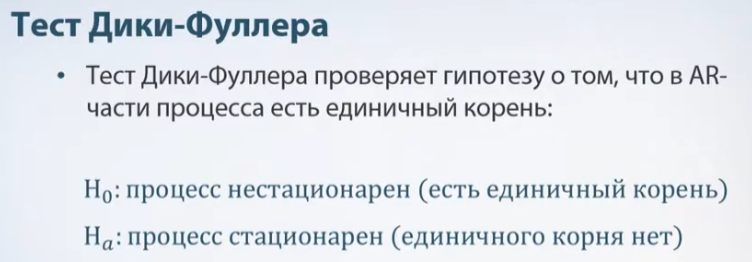

Стационарный временной ряд — это ряд, в котором статистические характеристики, такие как среднее и дисперсия, остаются постоянными с течением времени. Многие методы анализа и прогнозирования временных рядов предполагают стационарность данных. Если стационарность отсутствует или нарушена есть методы приведения (стреления, приближения) к стационарности для более верной работы модели прогнозирования. Это и требуют модели семейства ARIMA (4 вида: ARIMA, ARIMAX, SARIMA, SARIMAX)

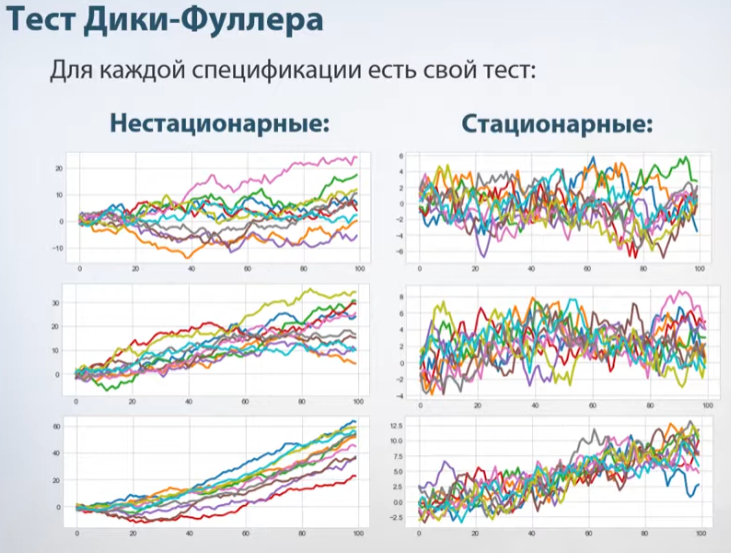

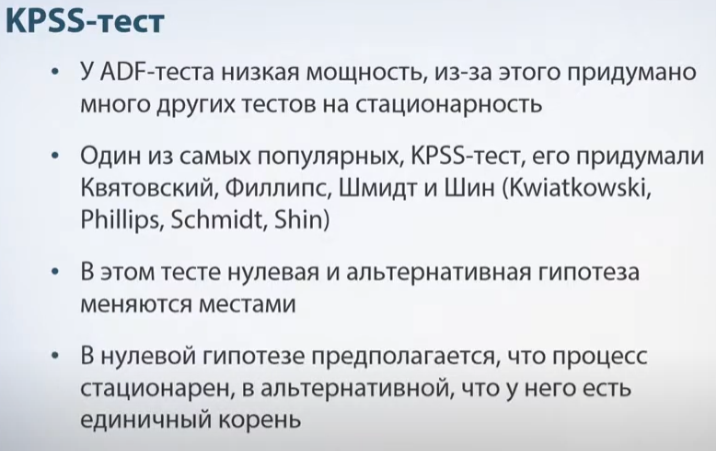

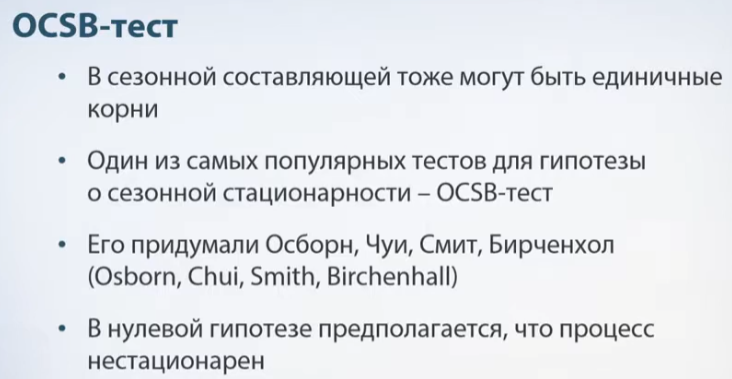

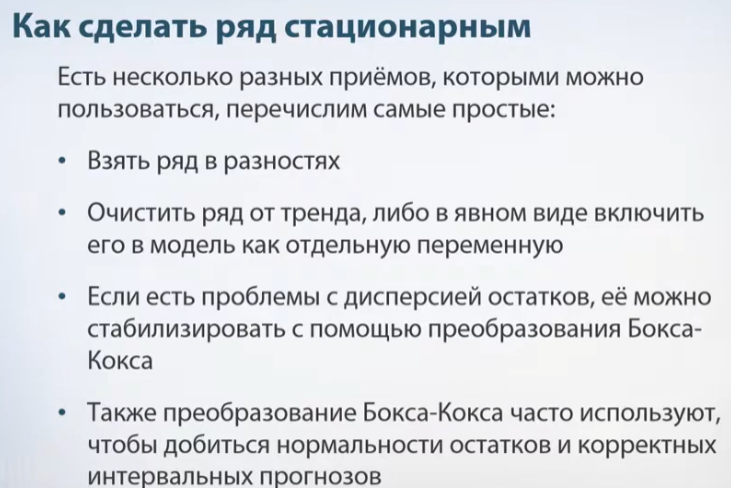

In [25]:
def return_interator_data_from_list(list_data: list, start, end):
    # yield
    ...

In [26]:
# now 10:04
# validate_result(model, "Linear", X_test, y_test, pred_window_size)
indexes_from_y_test = [date.index[0] for date in y_test[left_border:right_border:pred_window_size]]
real_y_test_df = pd.DataFrame({"Реальные данные": real_data}, indexes_from_y_test)
pred_X_test_df = pd.DataFrame({"Предсказанные данные":  np.nan}, indexes_from_y_test)
pred_X_test_df

,Предсказанные данные
2016-08-26,NaN
2016-08-27,NaN
2016-08-29,NaN
2016-08-30,NaN
2016-08-31,NaN
...,...
2017-04-14,NaN
2017-04-17,NaN
2017-04-18,NaN
2017-04-19,NaN


In [27]:
real_y_test_df.index[-1]

Timestamp('2017-04-20 00:00:00')

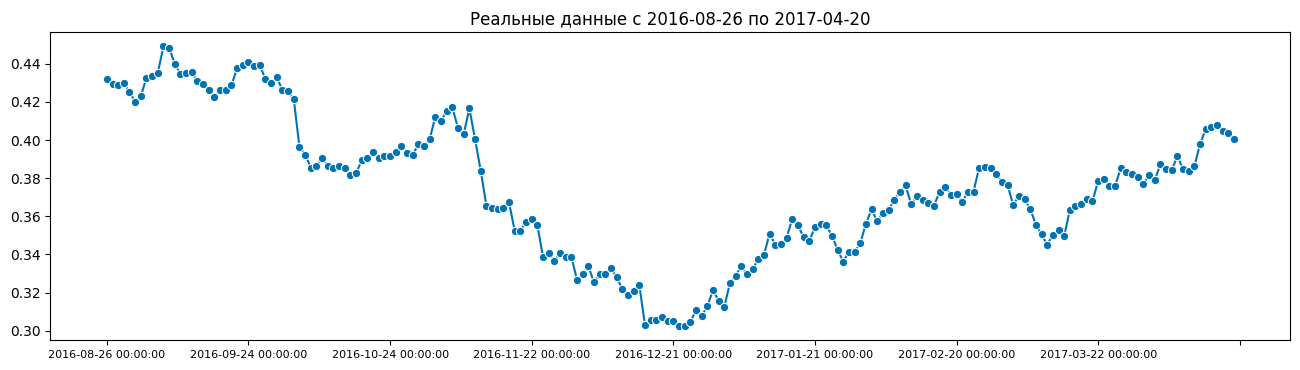

In [28]:
plot_series(real_y_test_df)
plt.title("Реальные данные c 2016-08-26 по 2017-04-20")
plt.tick_params(axis="x", which="major", labelsize = 8)
plt.tick_params(axis="y", which="major", labelsize = 10)


Проведём проверку гипотезы тестом Дики-Фуллера, с H0 - ряд стационарен, H1 - ряд нестационарен.

In [29]:
def count_adf_info(df, show=True):
    adf_info = adfuller(df, regression="n", autolag="AIC")
    p_value_adf0 = adf_info[1]
    if show:
        print(f"{adf_info=}")
        print(f"{p_value_adf0=}")
    return adf_info, p_value_adf0


adf_info, p_value_adf0 = count_adf_info(real_y_test_df)

adf_info=(-0.5228956890487355, 0.4866899148987226, 0, 199, {'1%': -2.5770667644756444, '5%': -1.942430759336949, '10%': -1.615550641718986}, -1354.001731852286)
p_value_adf0=0.4866899148987226


Значение p-value очень большое (даже без заданного наперёд уровень значимости, например, в 0.05).  Значит, наш ряд нестационарен.

Гипотезы меняются местами при KPSS-тесте. 

In [30]:
def count_kpss_info(df, show=True):

    kpss_info = kpss(df, regression="c")
    p_value_kpss0 = kpss_info[0]
    if show:
        print(f"{kpss_info=}")
        print(f"{p_value_kpss0=}")
    return kpss_info, p_value_kpss0
kpss_info, p_value_kpss0 = count_kpss_info(real_y_test_df)
print(f"{abs(p_value_adf0-p_value_kpss0)=}")

kpss_info=(0.7584547709636672, 0.01, 9, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
p_value_kpss0=0.7584547709636672
abs(p_value_adf0-p_value_kpss0)=0.2717648560649446


Примечание. На самом деле p-значение даже больше 0,1, но наибольшее значение, которое выводит функция kpss(), равно 0,1. Значения 0.01, 0.05 и 0.1 — типичные значения уровня значимости. Обычно значения, большие 0.1, не берутся. Поэтому здесь данная функция очень грубо, но округляет, давая понять туташняя гипотеза H0 неверна.

Здесь p-value явно больше чем какая-нибудь маленькая альфа-значимость. Это так же подверждает версию о том, что ряд нестационарен.

In [31]:
# X_test

In [32]:
data_from_y_train = [float(y_train[i].values) for i in range(len(y_train))]
indexes_from_y_train = [y_train[i].index[0] for i in range(len(y_train))]

In [33]:
data_from_y_test = [float(y_test[i].values) for i in range(len(y_test))]
indexes_from_y_test = [y_test[i].index[0] for i in range(len(y_test))]

In [34]:
def add_freq(idx, freq=None):
    """Add a frequency attribute to idx, through inference or directly.

    Returns a copy.  If `freq` is None, it is inferred.
    """

    idx = idx.copy()
    if freq is None:
        if idx.freq is None:
            freq = pd.infer_freq(idx)
        else:
            return idx
    idx.freq = pd.tseries.frequencies.to_offset(freq)
    if idx.freq is None:
        raise AttributeError('no discernible frequency found to `idx`.  Specify'
                             ' a frequency string with `freq`.')
    return idx

# Арима-модели

Одна из главных проблем реализации ARIMA-моделей — невозможность автоматически пропускать или прорабатывать пропущенные значения. Поэтому был реализован метод заполнения пустот средними соседей.

Вообще у нас датафрейм следующий...

In [35]:
def fill_na_with_mean_values(df):
    df_mean = (df.fillna(method='ffill').fillna(method='bfill') + df.fillna(method='bfill').fillna(method='ffill')) / 2
    return df_mean

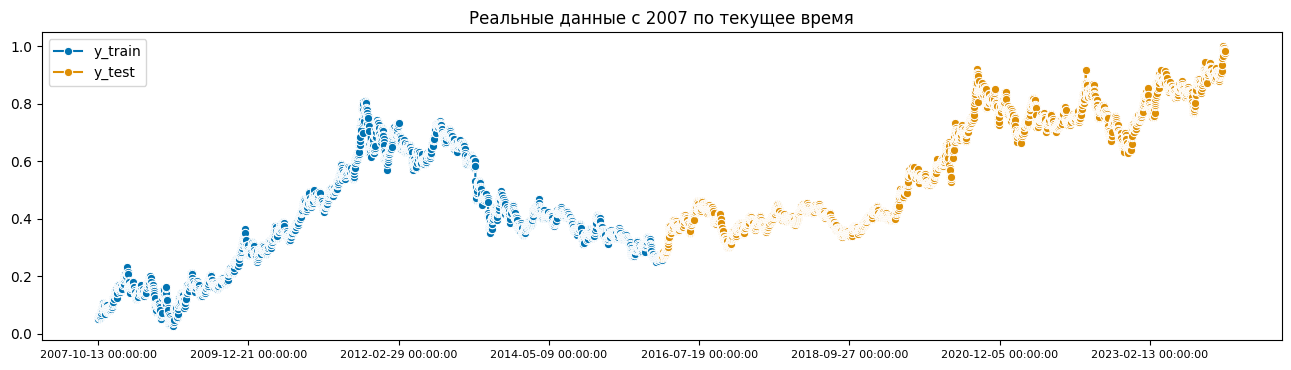

In [36]:
from sktime.forecasting.model_selection import temporal_train_test_split as tmp_tts
from sktime.forecasting.base import ForecastingHorizon
from pmdarima import model_selection

# y_train, y_test = tmp_tts(y, test_size=...)
# fh = ForecastingHorizon(y_test.index, is_relative=False)

y_train_df = pd.DataFrame({"Тренировочные данные": data_from_y_train}, indexes_from_y_train)
y_train_df = y_train_df.asfreq("D")
y_train_df = fill_na_with_mean_values(y_train_df)
y_test_df = pd.DataFrame({"Тестовые данные": data_from_y_test}, indexes_from_y_test)
y_test_df = y_test_df.asfreq("D")
y_test_df = fill_na_with_mean_values(y_test_df)

plot_series(y_train_df, y_test_df, labels=["y_train", "y_test"])
plt.title("Реальные данные c 2007 по текущее время")
plt.tick_params(axis="x", which="major", labelsize = 8)
plt.tick_params(axis="y", which="major", labelsize = 10)


In [37]:
# idx=pd.to_datetime(['2003-01-02', '2003-01-03', '2003-01-06'])  # freq=None

# idx.asfreq="d"

In [38]:
# print(add_freq(y_train_df.index))

In [39]:
print(count_adf_info(y_train_df))
print()
print(count_kpss_info(y_train_df))

adf_info=(-0.36218333677365433, 0.5517563870834372, 0, 3002, {'1%': -2.5664851726164346, '5%': -1.9410898459209813, '10%': -1.616731825865919}, -20113.677633401345)
p_value_adf0=0.5517563870834372
((-0.36218333677365433, 0.5517563870834372, 0, 3002, {'1%': -2.5664851726164346, '5%': -1.9410898459209813, '10%': -1.616731825865919}, -20113.677633401345), 0.5517563870834372)

kpss_info=(3.64816211034536, 0.01, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
p_value_kpss0=3.64816211034536
((3.64816211034536, 0.01, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}), 3.64816211034536)


In [40]:
print(count_adf_info(y_test_df))
print()
print(count_kpss_info(y_test_df))

adf_info=(1.240305617236487, 0.9447013406666117, 0, 2999, {'1%': -2.566485918440525, '5%': -1.9410899361684375, '10%': -1.616731737962061}, -20104.53420181644)
p_value_adf0=0.9447013406666117
((1.240305617236487, 0.9447013406666117, 0, 2999, {'1%': -2.566485918440525, '5%': -1.9410899361684375, '10%': -1.616731737962061}, -20104.53420181644), 0.9447013406666117)

kpss_info=(8.21334448330974, 0.01, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
p_value_kpss0=8.21334448330974
((8.21334448330974, 0.01, 32, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}), 8.21334448330974)


# Шаблоны тренировки ARIMA-моделей

Планируются для перебора параметры:

Обязательно:

seasonal: True, False (изначально нацеливаемся на наличие сезоности, но пока неизвестно)

m: 30, 90, 120, 365, 1000, 3000 (ежемесячно, ежеквартально, чуть больше ежеквартального, ежегодно, 1/5, 1/2 (тренд))

Опционально:

D: ... (при = 0 точно работает)

test: ...

seasonal_test: ...

Выборочно:

n_fits cовместно с random: потолок количества моделей и их способ их перебора (случайный или бинарно-поэтапный, или брут-форс), чтобы, с одной стороны, найти наилучшую точность, а с другой, не застрять во времени.

out_of_sample_size: количество прогнозируемых значений, которые пихаются в endog, а len(input)-out_of_sample_size — количество данных, на которых учится модель (тестовые). В зависимости от значений может вести себя как скользящее окно.





In [ ]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import pmdarima as pm


Внизу заданы параметры тренировки. Меняем только параметр m: 30, 90, 120, 365, 1000, 3003 (=len(y_train_df))

Сначала запускаете все ячейки выше, включая предыдущуюю с необходимыми import-ами, затем саму тренировку.

Под ячейкой происходит показ перебираемых моделей. Его надо сохранить (например в .txt-файл), для этого в месте вывода надо нажать "open in a text editor". Перебросит в новую вкладку VS Code, откуда спокойно всё можно скопировать. Если всё прошло ок, то в самом низу напишется лучшая модель. Но мне нужны все (я их остортирую и выберу 5-10 лучших)

Файлик вывода сохранить. Можно выложить в гит, указав, что для поиска использовался весь y_train_df (потом и его можно будет подвигать) и параметр m. Пример: 'find_best_sarima_model_100%_m=30.txt'

Если умерло ядро Jupyter, то делайте его Restart (соответсвующая кнопка сверху, запускайте ещё раз) и фиксируйте (сохраняйте) имеющийся вывод, будем из него искать.

In [41]:
# Before running this cell, run all above!!!
test_arima_model = auto_arima(

    y_train_df,
    start_p=1, start_q=1,
    max_p=5, max_q=5,

    seasonal=True, m=30,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,

    D=0,
    max_D=2, max_d=2,
    alpha=0.05, 
    test='kpss',
    seasonal_test='ocsb',

    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=False, 
    n_fits=100,
    information_criterion='bic',
    out_of_sample_size=7
)


 ARIMA(0,1,0)(0,0,0)[30] intercept   : BIC=-214.835, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[30] intercept   : BIC=-211.468, Time=0.27 sec
 ARIMA(0,1,0)(0,0,2)[30] intercept   : BIC=-208.101, Time=1.56 sec
 ARIMA(0,1,0)(1,0,0)[30] intercept   : BIC=-211.468, Time=0.37 sec
 ARIMA(0,1,0)(1,0,1)[30] intercept   : BIC=-208.101, Time=0.36 sec
 ARIMA(0,1,0)(1,0,2)[30] intercept   : BIC=-204.734, Time=0.93 sec
 ARIMA(0,1,0)(2,0,0)[30] intercept   : BIC=-208.101, Time=0.89 sec
 ARIMA(0,1,0)(2,0,1)[30] intercept   : BIC=-204.734, Time=1.09 sec
 ARIMA(0,1,0)(2,0,2)[30] intercept   : BIC=-201.366, Time=2.80 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : BIC=-212.968, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : BIC=-209.601, Time=0.43 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : BIC=-206.234, Time=1.51 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : BIC=-209.601, Time=0.71 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : BIC=-206.234, Time=0.65 sec
 ARIMA(0,1,1)(1,0,2)[30] intercept   : BIC=-202.866, Time=1.98

In [ ]:
# ARIMA(0,1,0)(0,0,0)[3000] intercept   : BIC=-20311.638, Time=0.37 sec

In [37]:
ARIMA_calc_params = '''
ARIMA(0,1,0)(0,0,0)[24] intercept   : BIC=-16702.326, Time=0.60 sec
ARIMA(0,1,0)(0,0,1)[24] intercept   : BIC=-16695.268, Time=10.75 sec
ARIMA(0,1,0)(0,0,2)[24] intercept   : BIC=-16687.335, Time=52.72 sec
ARIMA(0,1,0)(1,0,0)[24] intercept   : BIC=-16695.276, Time=6.90 sec
ARIMA(0,1,0)(1,0,1)[24] intercept   : BIC=-16687.425, Time=9.57 sec
ARIMA(0,1,0)(1,0,2)[24] intercept   : BIC=-16679.481, Time=44.78 sec
ARIMA(0,1,0)(2,0,0)[24] intercept   : BIC=-16687.514, Time=53.64 sec
ARIMA(0,1,0)(2,0,1)[24] intercept   : BIC=-16679.652, Time=55.14 sec
ARIMA(0,1,0)(2,0,2)[24] intercept   : BIC=-16671.846, Time=49.11 sec
ARIMA(0,1,1)(0,0,0)[24] intercept   : BIC=-16694.485, Time=3.42 sec
ARIMA(0,1,1)(0,0,1)[24] intercept   : BIC=-16687.424, Time=16.76 sec
ARIMA(0,1,1)(0,0,2)[24] intercept   : BIC=-16679.492, Time=47.98 sec
ARIMA(0,1,1)(1,0,0)[24] intercept   : BIC=-16687.432, Time=8.98 sec
ARIMA(0,1,1)(1,0,1)[24] intercept   : BIC=-16679.581, Time=21.93 sec
ARIMA(0,1,1)(1,0,2)[24] intercept   : BIC=-16671.637, Time=50.19 sec
'''
ARIMA_calc_params = ARIMA_calc_params.split('\n')[1:-1]
ARIMA_calc_params = [float(ARIMA_calc_params[i][42:52]) for i in range(len(ARIMA_calc_params))]
sorted(ARIMA_calc_params)[0:5] # => -16702.326, 

[-16702.326, -16695.276, -16695.268, -16694.485, -16687.514]

In [38]:
# test_arima_model.summary()

In [39]:
# test_arima_model.plot_diagnostics(figsize=(10, 8))

После нахождения подходящих параметров, строим прогнозы на основе массивов лучших параметров.

Сравнить AIC с моделью из main (оптимизировать (уменьшить или увеличить) при случае)

In [40]:
# ARIMA construction
# ---arima = sm.tsa.statespace.SARIMAX(validation_X, order=(1,1,2),seasonal_order=(0,0,0,0)).fit()


'''for column in validation_X.columns:
    arima = sm.tsa.statespace.SARIMAX(validation_X[column], order=(7,1,7),seasonal_order=(0,0,0,0), simple_differencing=True).fit()'''
# arima = sm.tsa.statespace.SARIMAX(validation_X, order=(1,1,2),seasonal_order=(0,0,0,0)).fit()

# ---target_adj_close[1400:].plot()

# validation_X["Open"].isnull().sum() # 0
# test starts at 2018-01-22
'''
predicted = model.predict(validation_X)
RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))

axes[ax_x][ax_y].plot(validation_y.index, predicted,'y', label='Predict')
axes[ax_x][ax_y].plot(validation_y.index, validation_y,'b', label='Actual')
'''

# ---arima.predict(start="2018-01-22", dynamic=False).plot()

# 2018-12-28
# X_train.columns

"\npredicted = model.predict(validation_X)\nRSME_score = np.sqrt(mean_squared_error(validation_y, predicted))\n\naxes[ax_x][ax_y].plot(validation_y.index, predicted,'y', label='Predict')\naxes[ax_x][ax_y].plot(validation_y.index, validation_y,'b', label='Actual')\n"

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

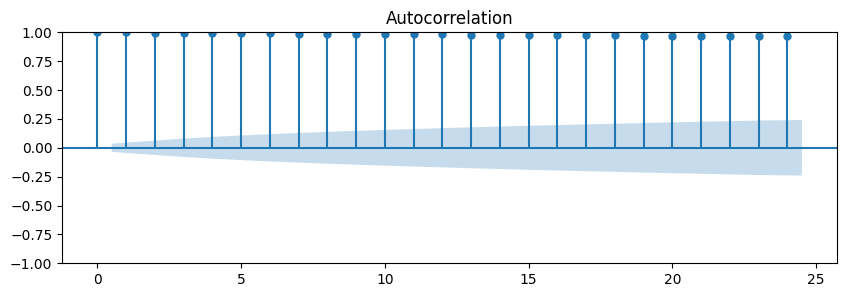

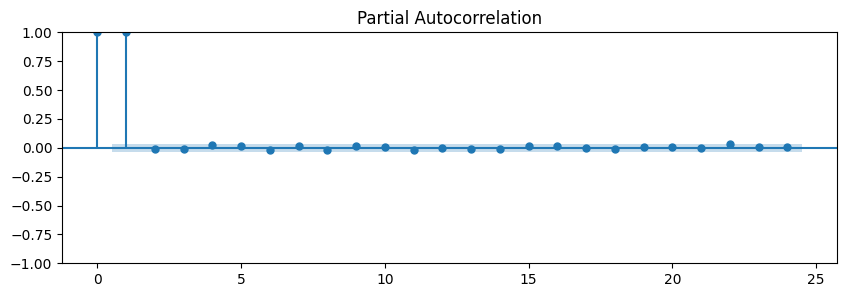

In [44]:
plt.rcParams.update({'figure.figsize': (10,3)})
plot_acf(y_train_df, lags=24)
plot_pacf(y_train_df, lags=24)
plt.show()

In [154]:
# ARIMA(0,1,0)(0,0,1)[24] intercept   : BIC=-16695.268, Time=10.75 sec
model1 = sm.tsa.statespace.SARIMAX(y_train_df,
                                   order=(0, 1, 0),
                                   seasonal_order=(0, 0, 1, 24))
res_model1 = model1.fit()
print(res_model1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L24       0.0069      0.017      0.416      0.677      -0.026       0.039
sigma2       6.71e-05   7.35e-07     91.303      0.000    6.57e-05    6.85e-05


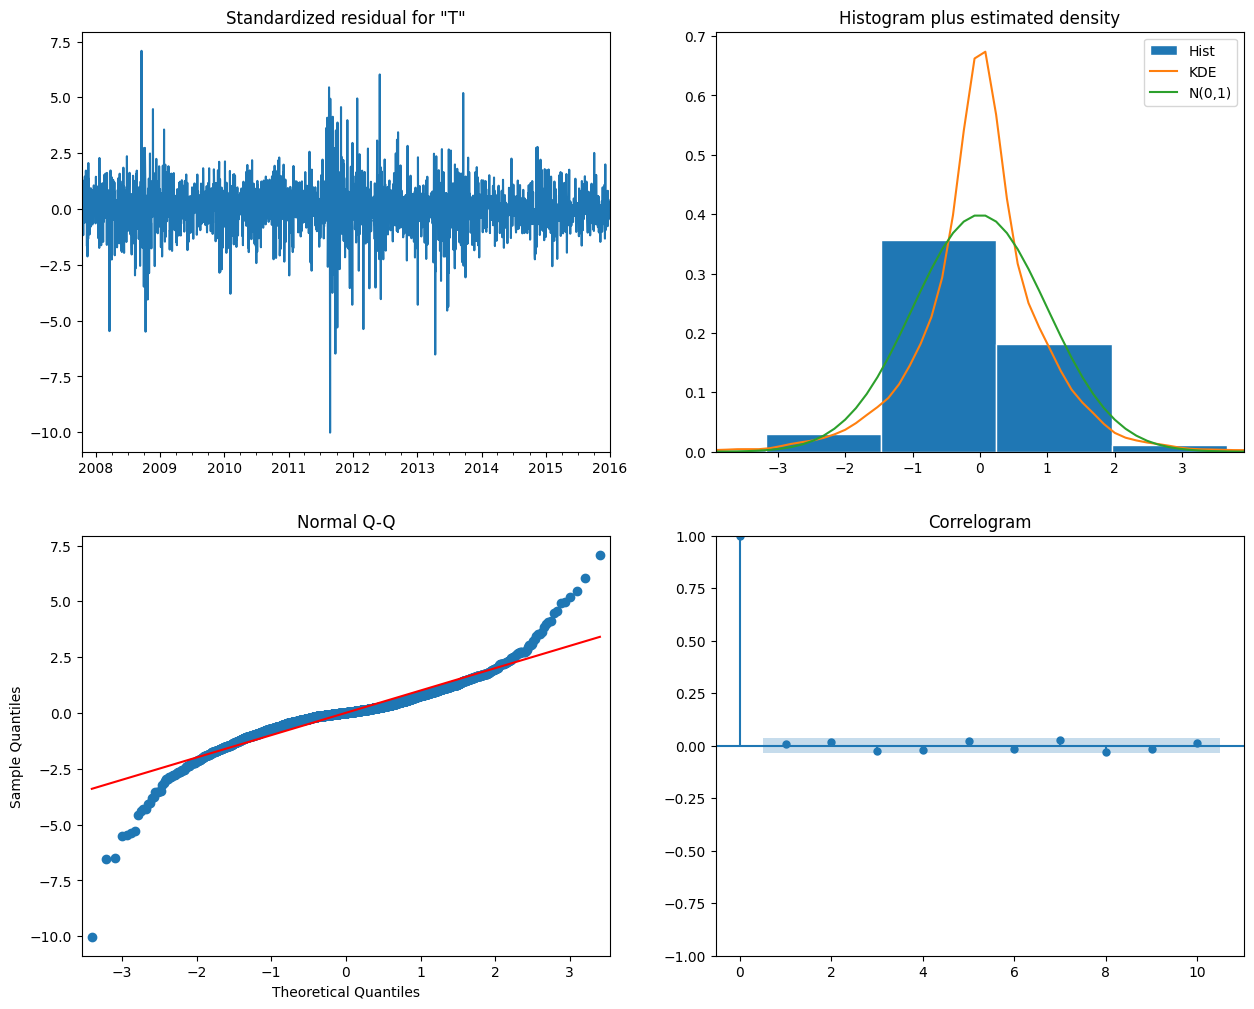

In [155]:
res_model1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [156]:
predict1=res_model1.get_prediction()
predict1.predicted_mean[:10]

2007-10-13    0.000000
2007-10-14    0.052938
2007-10-15    0.052409
2007-10-16    0.051879
2007-10-17    0.058033
2007-10-18    0.060416
2007-10-19    0.056776
2007-10-20    0.065643
2007-10-21    0.063195
2007-10-22    0.063757
Freq: D, Name: predicted_mean, dtype: float64

<Figure size 15500x6000 with 0 Axes>

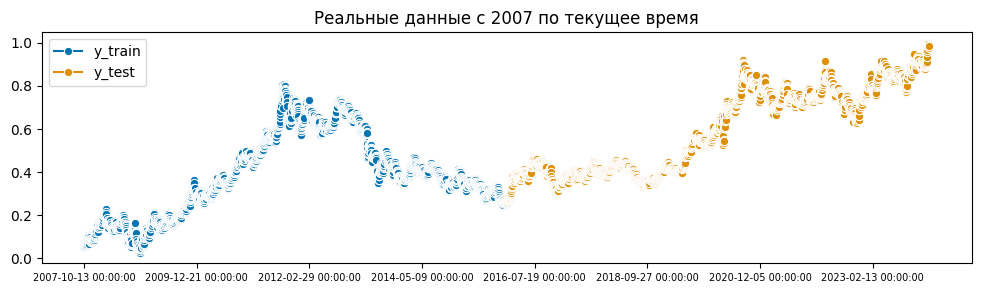

In [157]:
plt.figure(figsize=(155, 60))

plot_series(y_train_df, y_test_df, labels=["y_train", "y_test"])
plt.title("Реальные данные c 2007 по текущее время")
plt.tick_params(axis="x", which="major", labelsize = 7)
plt.tick_params(axis="y", which="major", labelsize = 10)

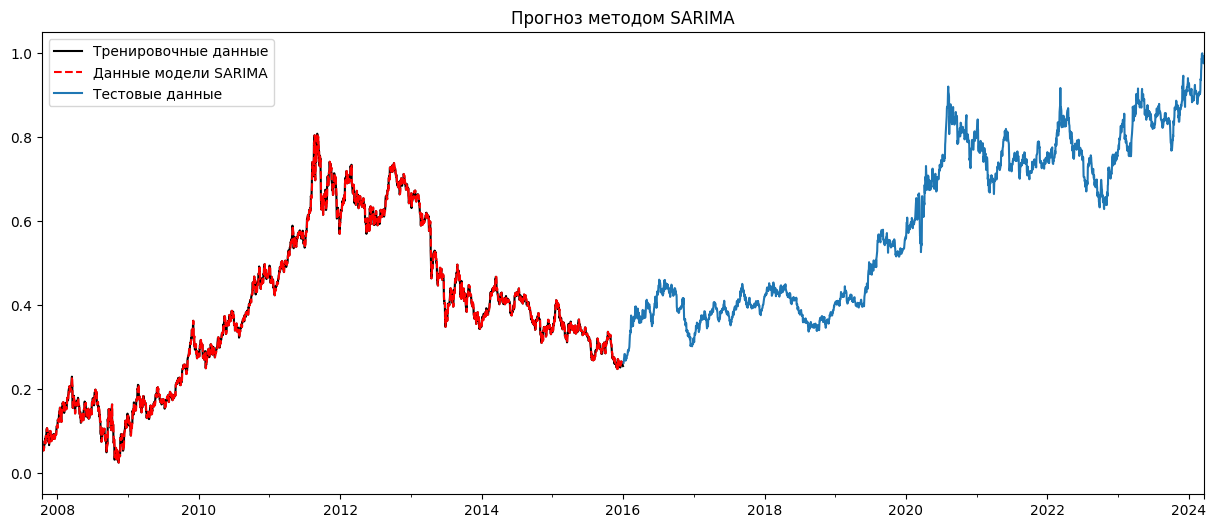

In [172]:
# predict1=res_model1.get_prediction(start='2019', end='2021')
# ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
# ax = plot_series(y_train_df, y_test_df, labels=["y_train", "y_test"])
y_train_and_test_df = y_train_df + y_test_df
ax = y_train_df.plot(figsize=(15,6), color='black', 
                     title="Прогноз методом SARIMA" )
res_model1.fittedvalues.plot(ax=ax, style='--', color='red', )
y_test_df.plot(ax=ax)
plt.legend(labels=["Тренировочные данные", 
                   "Данные модели SARIMA",
                   "Тестовые данные"])
plt.show()

In [175]:
_mape_(y_train_df, res_model1.fittedvalues)

45.224461195272255

# Наивный прогноз

In [91]:
y_test_df_10n_copy = y_test_df.copy()
y_test_df_10n_copy = y_test_df_10n_copy * (10**5)
y_test_df_10n_copy = y_test_df_10n_copy.astype(np.int64)


In [92]:
y_test_df_10n_copy

,Тестовые данные
2016-01-04,26283
2016-01-05,26601
2016-01-06,27124
2016-01-07,27838
2016-01-08,27984
...,...
2024-03-16,98405
2024-03-18,97604
2024-03-19,98597
2024-03-20,98471


In [106]:
y_test_df.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-09', '2016-01-11', '2016-01-12',
               '2016-01-13', '2016-01-14',
               ...
               '2024-03-09', '2024-03-11', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-16', '2024-03-18', '2024-03-19',
               '2024-03-20', '2024-03-21'],
              dtype='datetime64[ns]', length=2547, freq=None)

In [ ]:
fh = ForecastingHorizon(y_test_df.index, is_relative=False)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

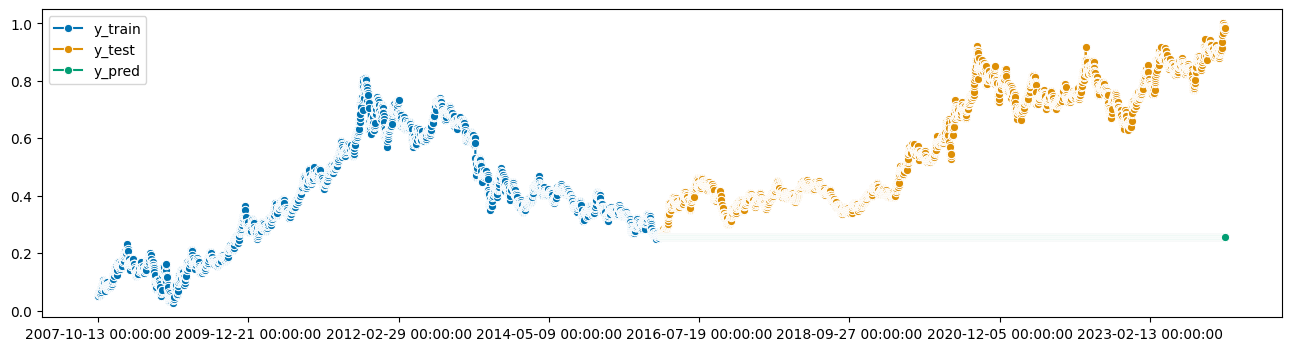

In [178]:
from sktime.forecasting.naive import NaiveForecaster

# y_train_df.index = y_train_df.index.to_period('D')
# y_train_df.index.freq = 'D'
# y_test_df.index.freq = 'D'

forecaster = NaiveForecaster(strategy='last')
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])


In [181]:
_mape_(y_pred, y_test_df)

134.42825899031814

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

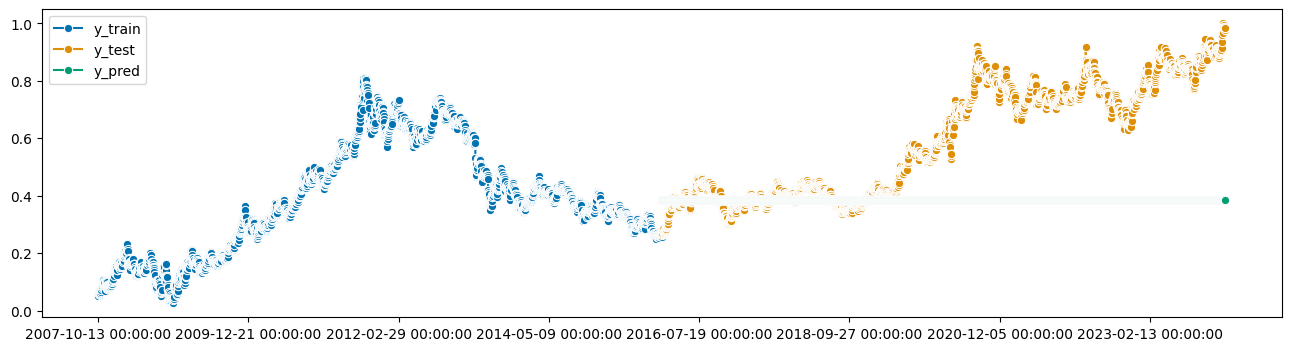

In [185]:
forecaster = NaiveForecaster(strategy='mean', window_length=3000)
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])


In [184]:
_mape_(y_pred, y_test_df)

57.80025744745419

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

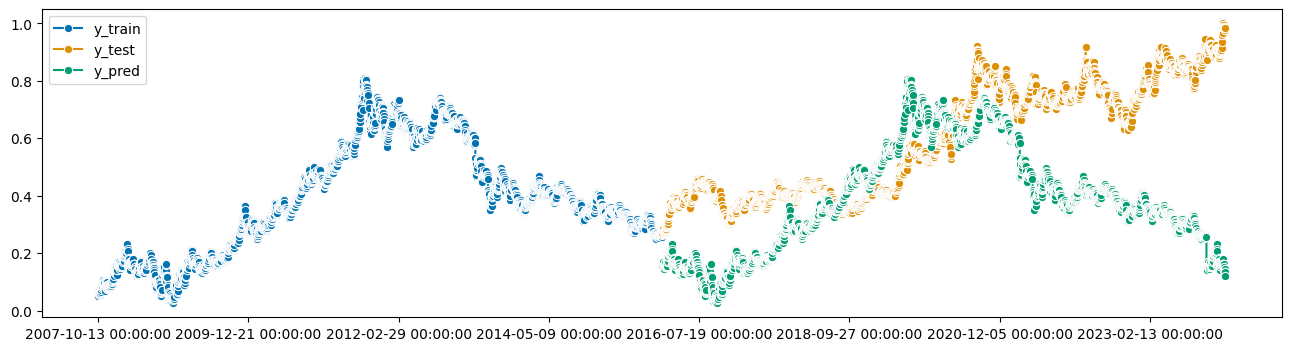

In [207]:
forecaster = NaiveForecaster(strategy='last', sp=(len(y_test_df)+len(y_train_df))//2-100)
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])

In [208]:
_mape_(y_pred, y_test_df)

104.49896691601252

# ETS-модели

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

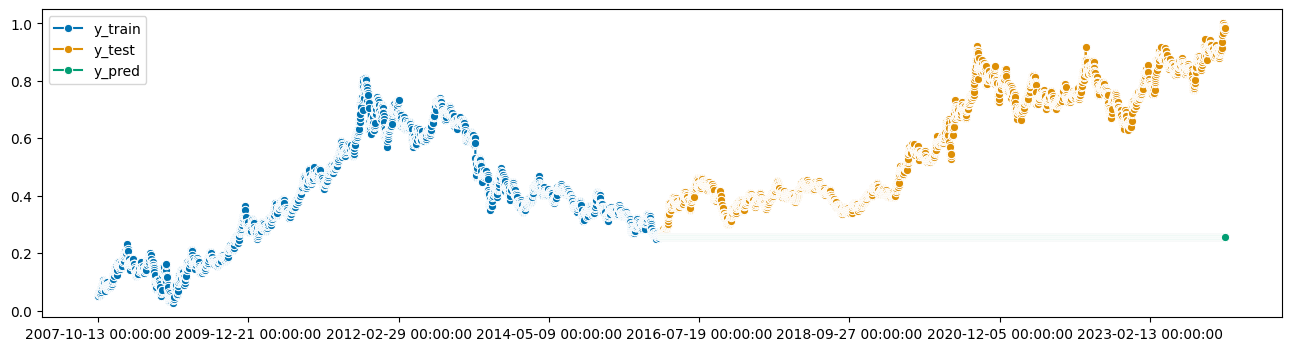

In [209]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

forecaster = ExponentialSmoothing()
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])

In [210]:
_mape_(y_pred, y_test_df)

134.42825898035295

In [211]:
forecaster.get_fitted_params()

{'initial_level': 0.05312514815005338,
 'initial_slope': None,
 'initial_seasons': array([], dtype=float64),
 'aic': -28853.365234828587,
 'bic': -28841.35050069262,
 'aicc': -28853.351892600436}

In [213]:
# forecaster.predict(fh, return_pred_int=True, alpha=0.95)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

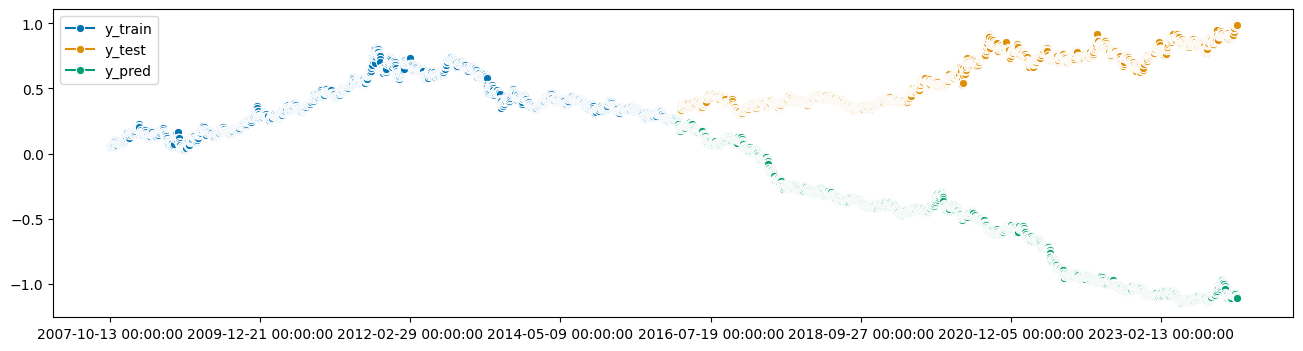

In [243]:
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=1500)
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])
# 2m 44s

In [261]:
y_pred = y_pred*1.5

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

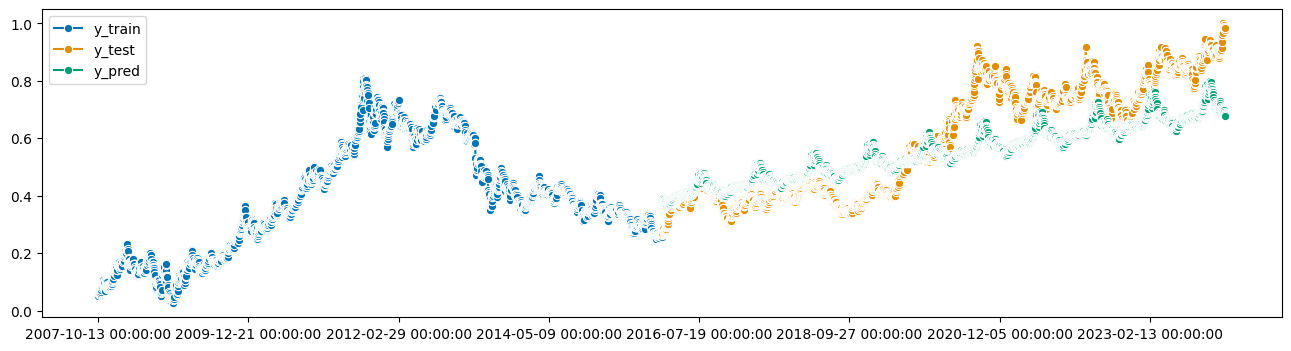

In [263]:
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=300)
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])

In [264]:
_mape_(y_pred, y_test_df) # Вообще мимо

18.914756618734398

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

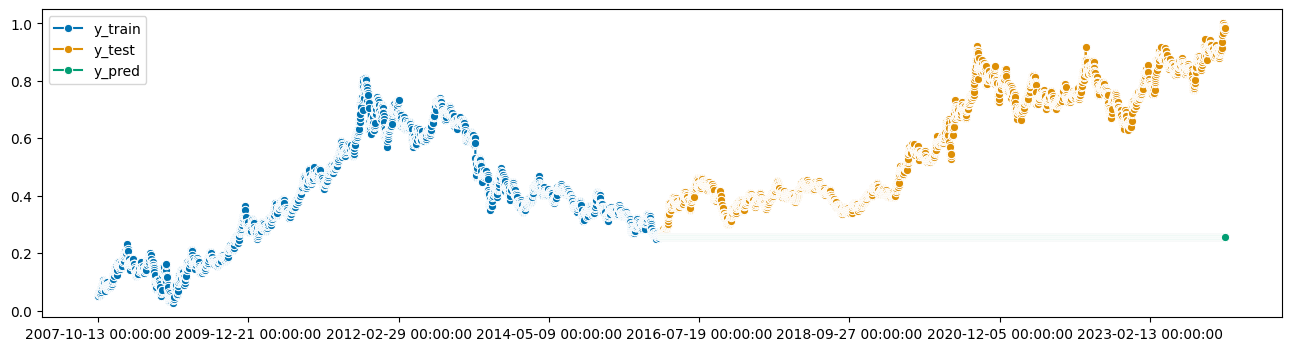

In [232]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True,
                     n_jobs=-1,
                     information_criterion='bic')
forecaster.fit(y_train_df)

y_pred = forecaster.predict(fh)

plot_series(y_train_df, y_test_df, y_pred, labels=["y_train", "y_test", "y_pred"])

In [244]:
_mape_(y_pred, y_test_df)

268.8468207975403

# Преобразование Бокса Кокса

In [ ]:
from pmdarima.pipeline import Pipeline as pmPipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

arima_pipeline = pmPipeline([
    ("boxcox", BoxCoxEndogTransformer(),
     "model", pm.AutoARIMA(seasonal=True, suppress_warnings=True))
])

Надо ли? 

В рамках пакетов sktime и pmdarima можно делать трансформацию данных и собирать пайплайны также, как и в sklearn. Например, перед обучением модели можно сделать преобразование Бокса-Кокса. Его обычно используют для того, чтобы стабилизировать дисперсию остатков и сделать их нормальными. 

Вот надо узнать, что с остатками дисперсий.